# Imports and data 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
calls = {}
for c in ['uk', 'uk2', 'mit']:
    calls[c] = pc.apply_filters(unfiltered[c], 60)

globalt0 = dt.datetime.now()

# New Fig 1

In [2]:
limits = {}
limits['uk'] = [(0, 60), (100, 160), (220, 280)]
limits['uk2'] = [(0, 60), (100, 160), (220, 280)]
limits['it'] = [(0, 100), (150, 250), (300, 400)]
limits['mit'] = [(0, 50), (100, 150), (200, 250)]

In [3]:
fig1 = {}
for c in calls.keys():
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], 15)

In [4]:
t0 = dt.datetime.now()

fig1['it'] = {}
for i in range(3):
    fig1['it'][i] = {}
    fig1['it'][i]['f'] = pc.get_avgfa(itdffa15[60], itlives[60], limits['it'][i][0], limits['it'][i][1])
    fig1['it'][i]['fi'] = {}
    for ego in itdffa15[60].keys():
        tmp = {ego: itdffa15[60][ego]}
        fig1['it'][i]['fi'][ego] = pc.get_avgfa(tmp, itlives[60], limits['it'][i][0], limits['it'][i][1])
        
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.536168


In [5]:
dashed = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1[c].keys():
        if lamb > 0:
            points = pc.get_plateau(fig1[c][lamb]['f'], pstar=0.01)
            dashed[c][lamb] = [[x[0] for x in points], [y[1] for y in points]]
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[0][1]}) -- (axis cs: {points[1][0]}, {points[1][1]});')

=======================uk=====================
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.252273105486776) -- (axis cs: 8, 1.252273105486776);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 1.9359327049218318) -- (axis cs: 17, 1.9359327049218318);
=======================uk2=====================
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.492559545613117) -- (axis cs: 8, 1.492559545613117);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 2.5003114576583987) -- (axis cs: 17, 2.5003114576583987);
=======================it=====================
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 0.630617860901637) -- (axis cs: 14, 0.630617860901637);
\draw[dashed, ekans, ultra thick] (axis cs: 5, 1.6663645671867846) -- (axis cs: 21, 1.6663645671867846);
=======================mit=====================
\draw[dashed, squirtle, ultra thick] (axis cs: 3, 1.990001693503304) -- (axis cs: 7, 1.990001693503304);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 3.8297768234446457) -- (axi

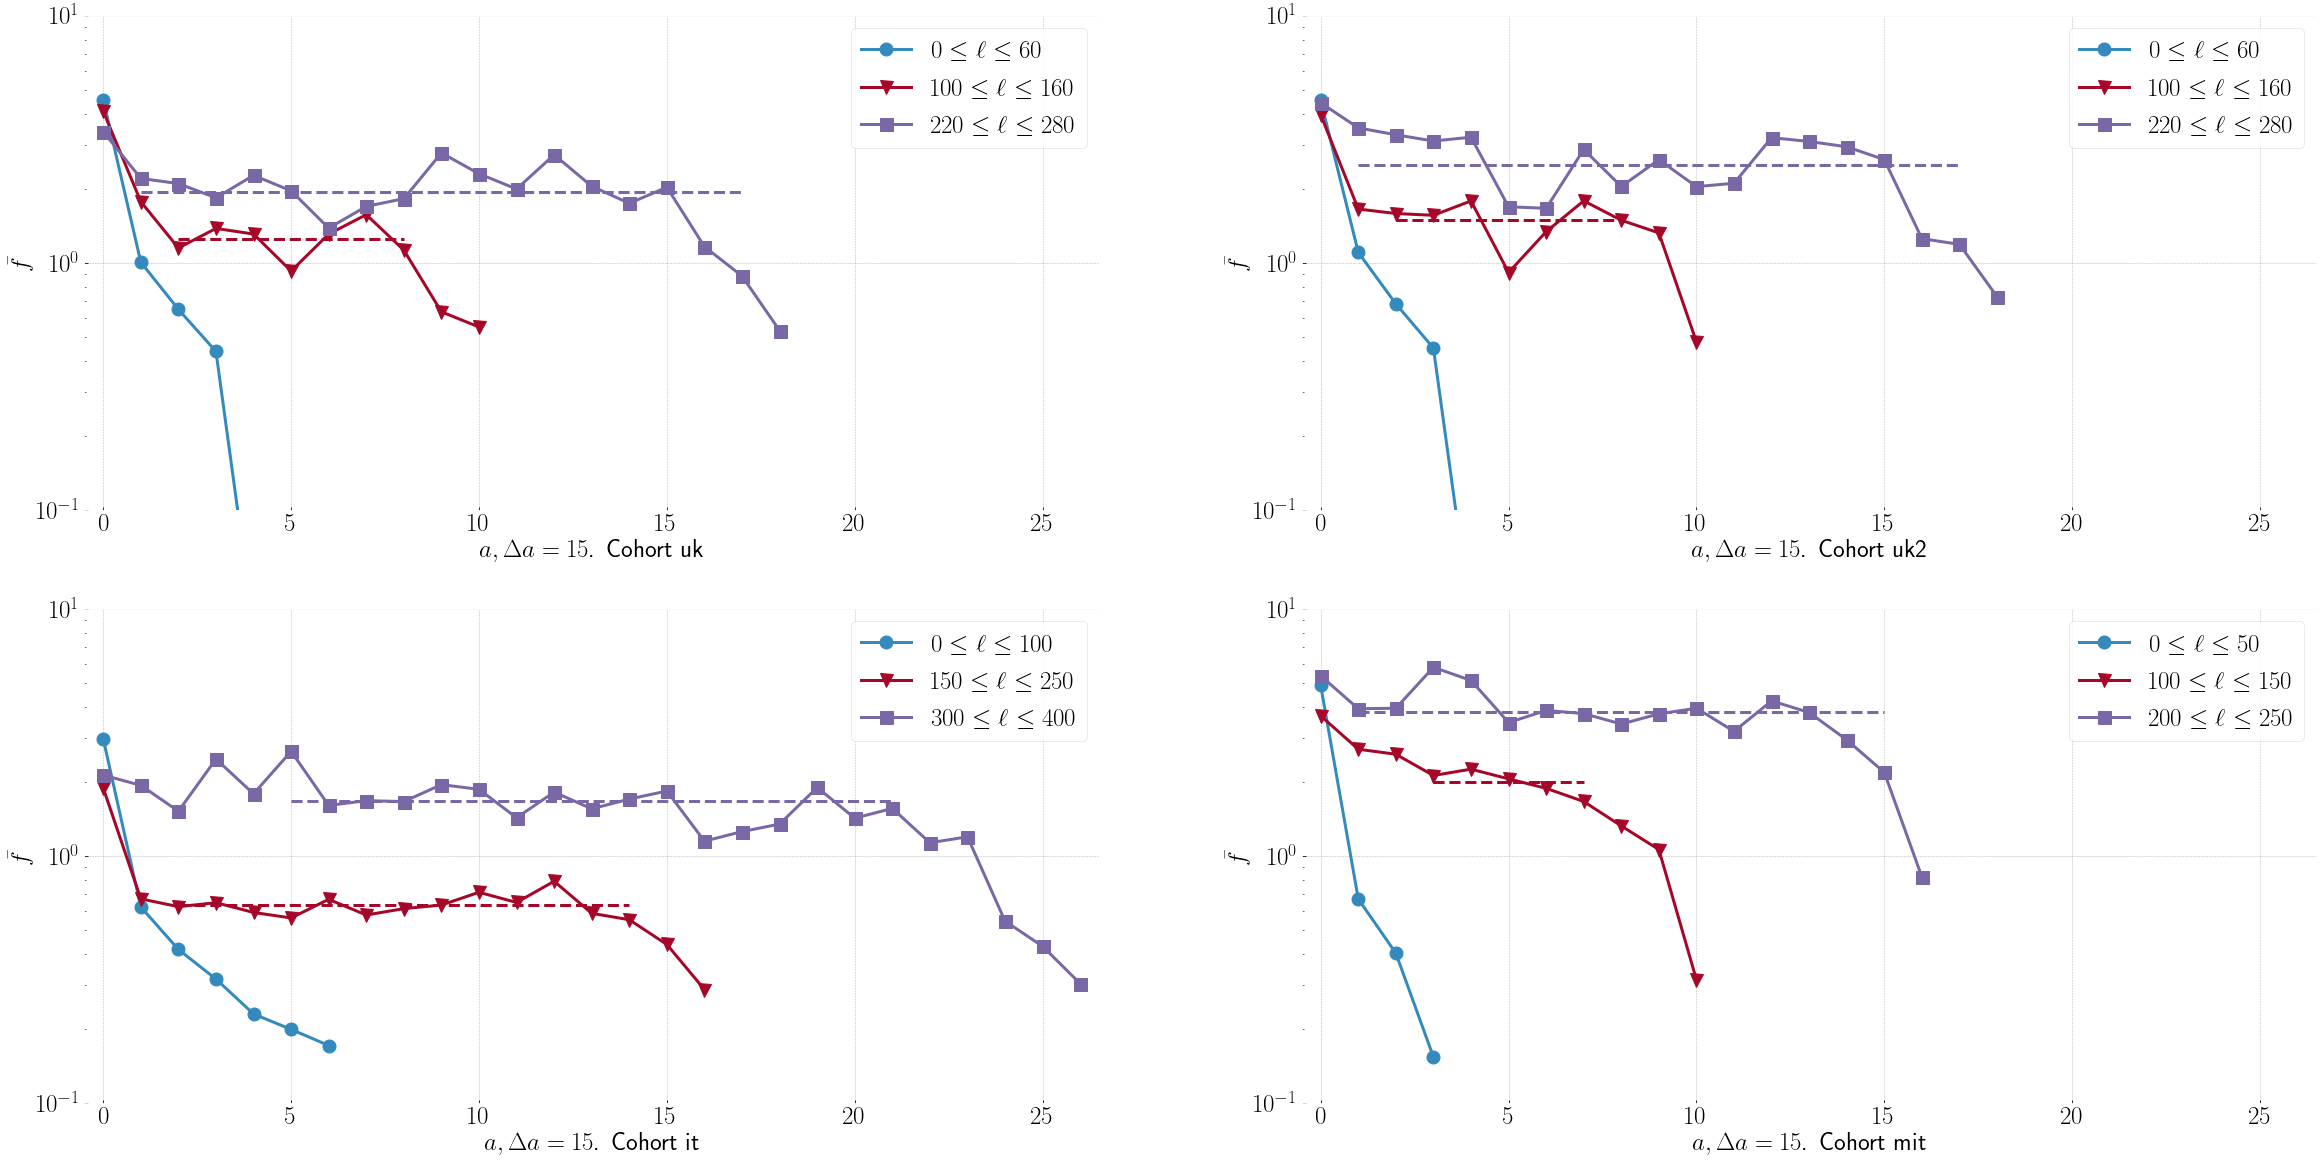

In [6]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    plt.ylim(10**(-1), 10**1)
    plt.semilogy()
    plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]}$')
        if i > 0:
            plt.plot(dashed[c][i][0], dashed[c][i][1], marker="", ls="--", lw=3, c=colors[i])
    plt.legend()
    p += 1
# plt.savefig("/home/vsvh/Desktop/B.png", dpi=200, pad_inches=2)

In [39]:
# for c in fig1.keys():
#     tmp = pd.DataFrame()
#     for l in fig1[c].keys():
#         df = fig1[c][l]['f']
#         df.columns = [f'l{int(l)}']
#         if len(tmp) == 0:
#             tmp = tmp.append(df)
#         else:
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#     tmp.index.rename('a', inplace=True)
#     tmp.fillna('nan', inplace=True)
#     #tmp = tmp.loc[tmp.index < 13]
#     tmp.to_csv(f"../commpatterns/PNAS_paper/figs/fig1_{c}.dat", header=True, sep="\t")

## Fig 1b

30 egos randomly chosen

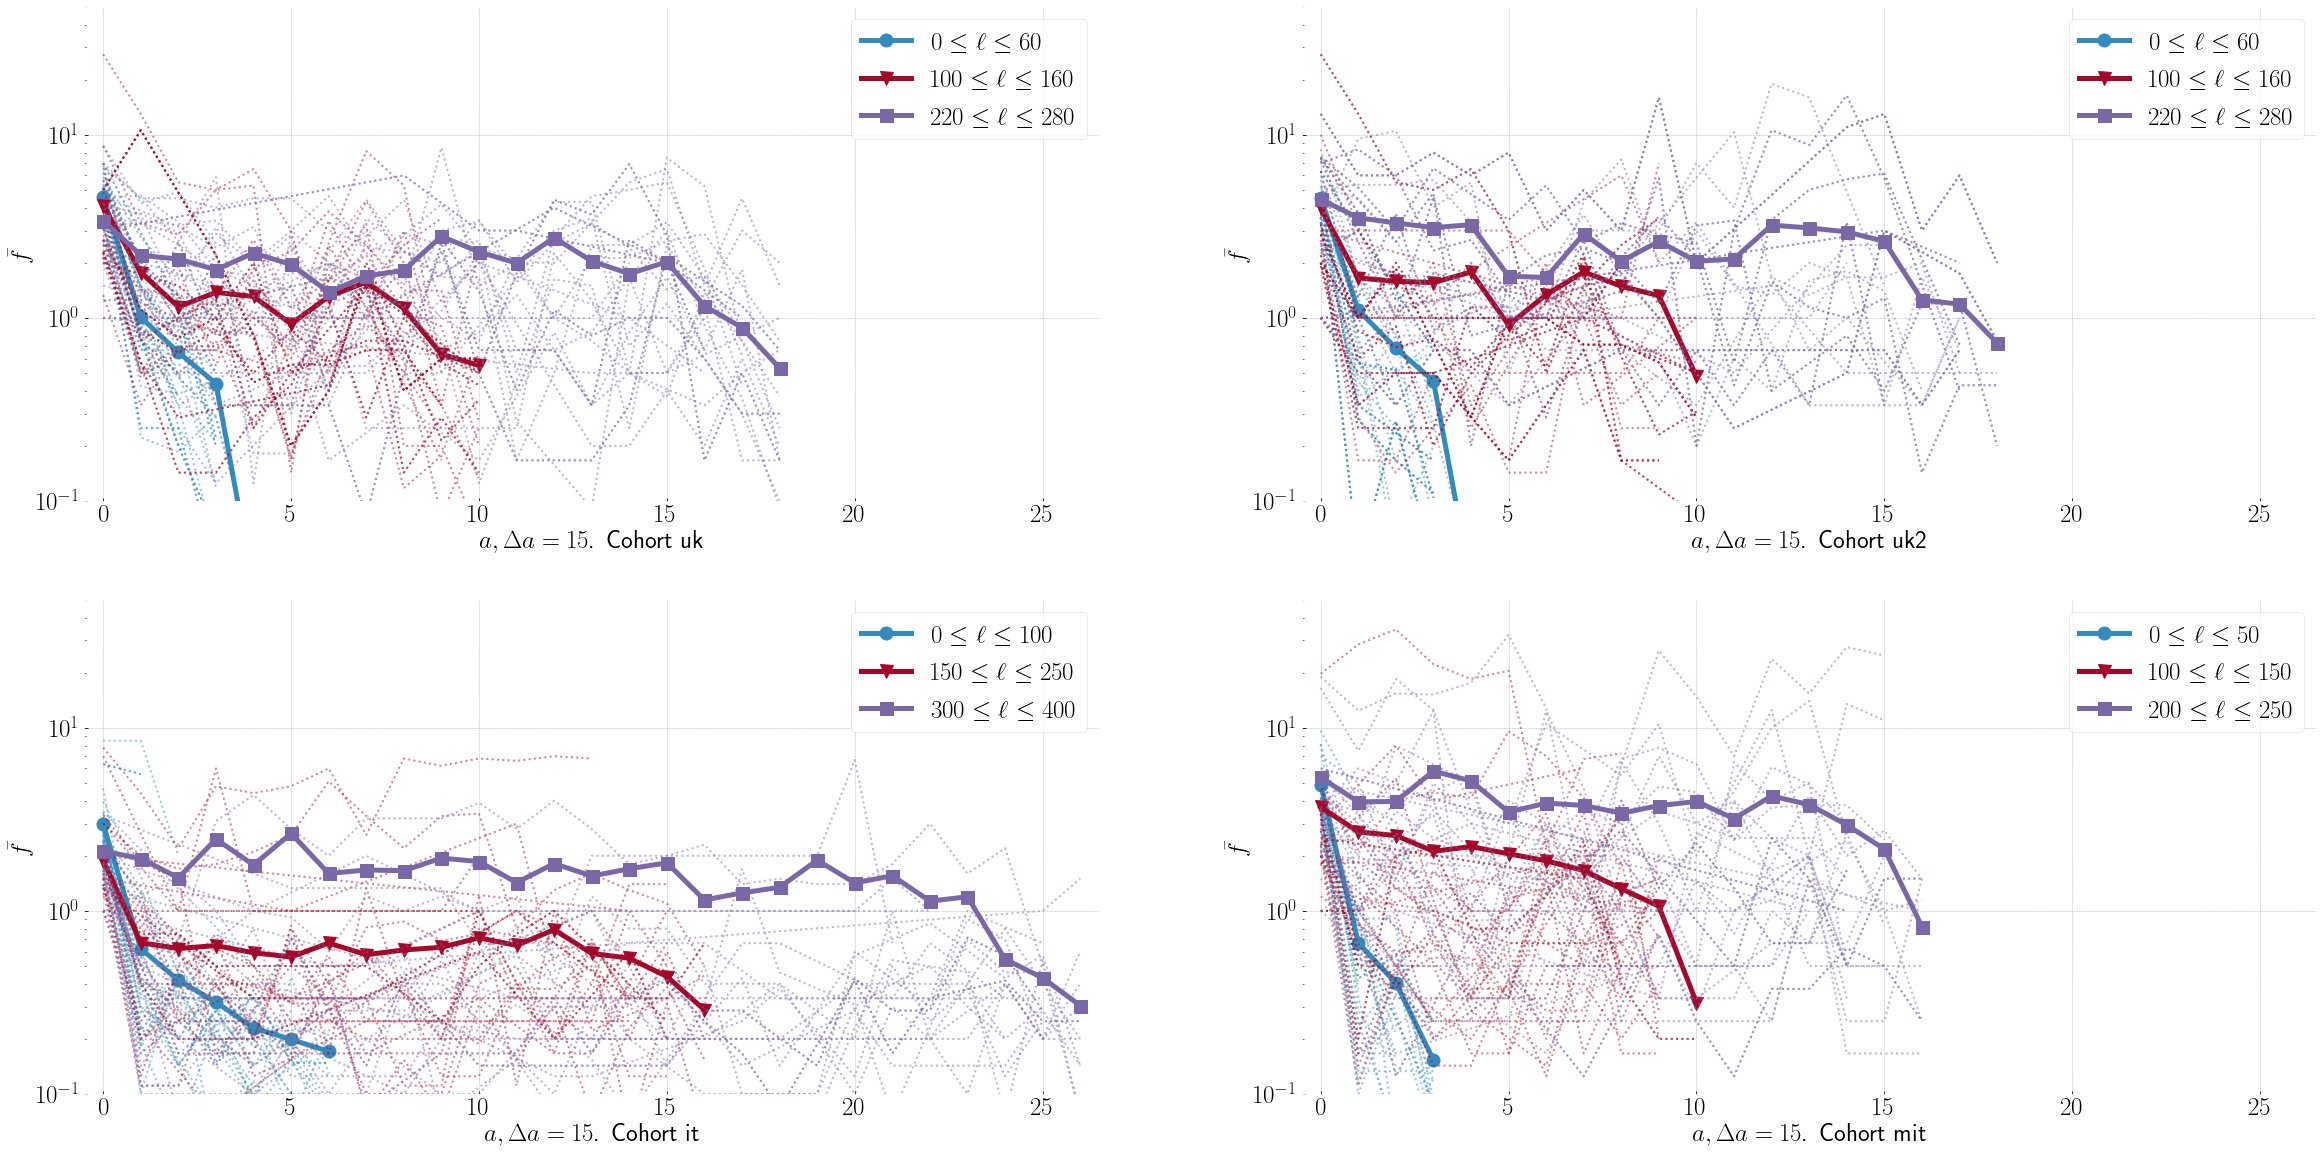

In [7]:
np.random.seed(0)
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    plt.ylim(10**(-1), 5*10**1)
    plt.semilogy()
    plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=5, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]}$')
        egos = np.random.choice(list(fig1[c][i]['fi'].keys()), size=30)
        for e in egos:
            plt.plot(fig1[c][i]['fi'][e].index, fig1[c][i]['fi'][e]['f'], marker="", ls="dotted", lw=2, c=colors[i], alpha=0.5)
    plt.legend()
    p += 1
# plt.savefig("/home/vsvh/Desktop/A.png", dpi=200, pad_inches=2)

# Fig 3 (survival curves)

In [19]:
dff = {}
dff['all'] = {}
for c in calls.keys():
    dff[c] = pc.get_f(calls[c], 'all', 30, 10)
    dff['all'].update(dff[c])
    
dff['it'] = itdffa30[60]
dff['all'].update(dff['it'])

In [27]:
survival = {}
for c in dff.keys():
    survival[c] = pc.get_survival(dff[c], lambdamax=25)

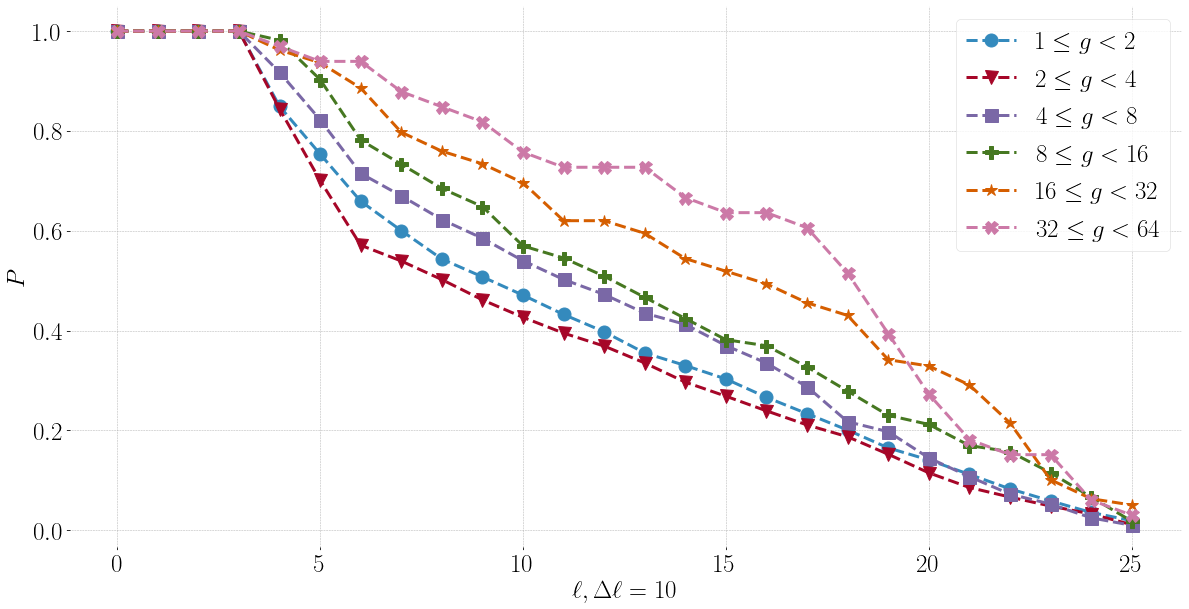

In [28]:
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(6):
    plt.plot(survival['all'][i].index, survival['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
plt.legend()

In [40]:
# tmp = pd.DataFrame({'lc': list(survival['all'][0].index)})
# for s in range(6):
#     df = survival['all'][s]
#     tmp[f'p{int(s)}'] = df[0]
# tmp.to_csv(f'../commpatterns/PNAS_paper/figs/allsurvival.dat', header=True, index=False, sep="\t")

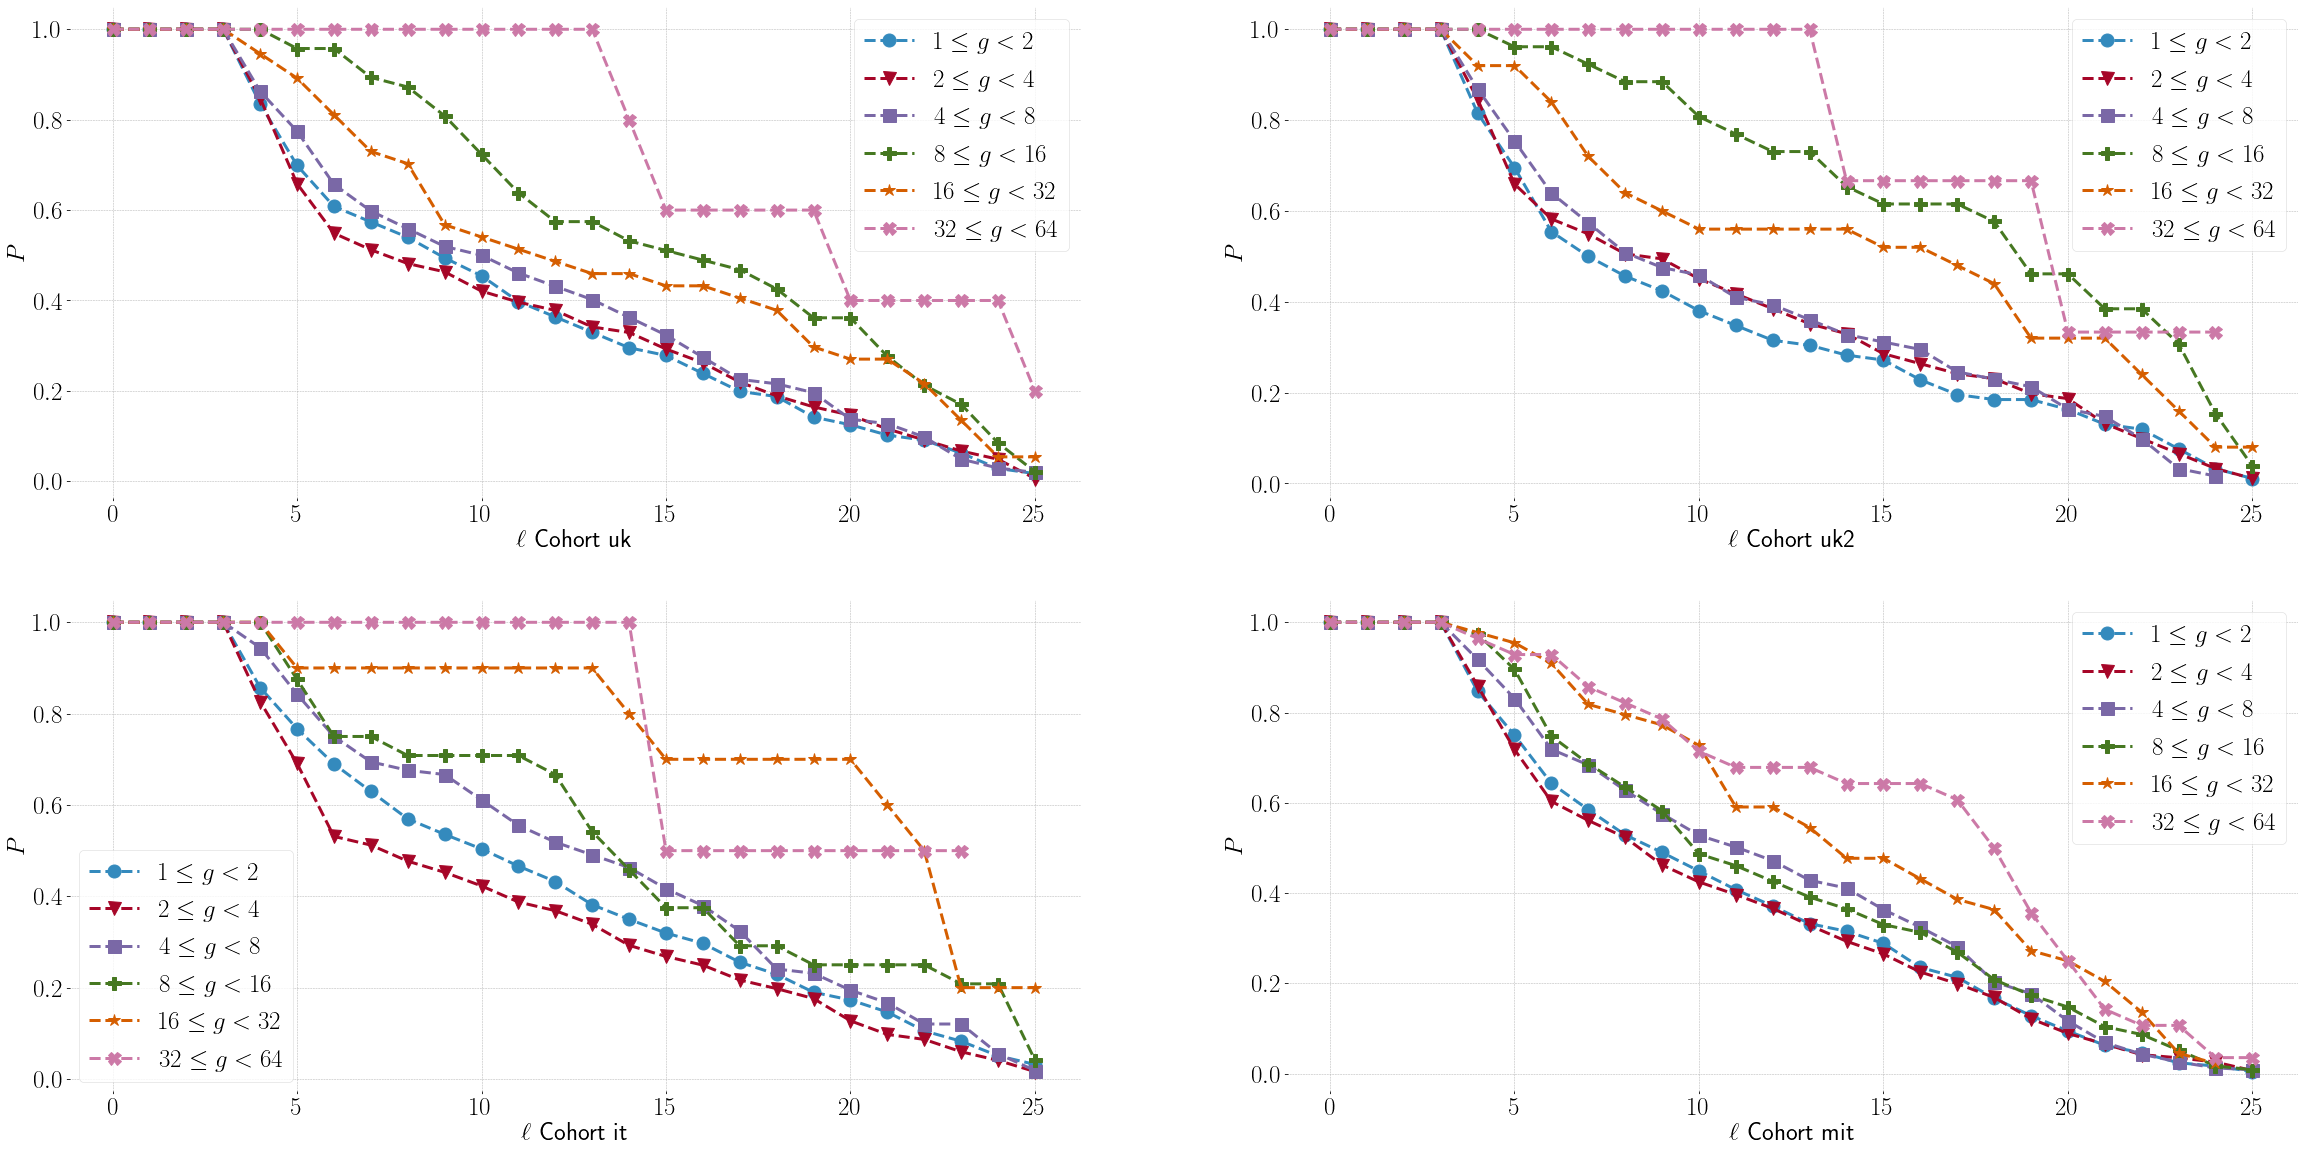

In [23]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel(fr"$\ell$ Cohort {c}")
    plt.ylabel(r"$P$")
    for i in range(6):
        plt.plot(survival[c][i].index, survival[c][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
    plt.legend()
    p += 1
#plt.savefig("/home/vsvh/Desktop/C.png", dpi=200, pad_inches=2)

# Fig 4 (contours) 

In [32]:
dffUM = {}
for c in ['uk', 'mit']:
    dffUM.update(dff[c])
    
surv_cont = pc.get_survival(dffUM, lambdamax = 25)

In [34]:
tmp = pd.DataFrame()
for s in range(6):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 2**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
tmp.to_csv(f"../commpatterns/PNAS_paper/figs/contour.dat", header=False, index=False, sep="\t")

In [35]:
points_it = pc.get_survival(dff['it'], unbinned=True, lambdamax=25)

tmp = pd.DataFrame()
for s in points_it.keys():
    if s <= 2**5 + 1:
        df = points_it[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
for s in sub:
    df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
    df = df.drop(columns='z')
    df.to_csv(f'../commpatterns/PNAS_paper/figs/points{p}.dat', header=False, index=False, sep="\t")
    print(s)
    p += 1

(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)


<center><img src="contours.png" style="width: 50%"/></center>

# Check for ecological fallacy

In [8]:
a = {}
a[15] = {}
a[15][1] = (1, 5, 9)
a[15][2] = (2, 8, 14)
a[10] = {}
a[10][1] = (1, 7, 13)
a[10][2] = (2, 12, 22)
a[7] = {}
a[7][1] = (1, 10, 19)
a[7][2] = (2, 17, 32)
a[5] = {}
a[5][1] = (2, 15, 28)
a[5][2] = (2, 23, 44)
a[3] = {}
a[3][1] = (4, 25, 46)
a[3][2] = (2, 40, 78)

In [9]:
ksp = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    ksp[c] = {}
    for Da in a.keys():
        ksp[c][Da] = {}
        series = pc.get_fal(calls[c], 100, 150, Da)
        for ego in series['fi'].keys():
            df = series['fi'][ego]
            left = df.loc[(df.index >= a[Da][1][0]) & (df.index <= a[Da][1][1])]
            right = df.loc[(df.index >= a[Da][1][1]) & (df.index <= a[Da][1][2])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c][Da]['m'] = ksp[c][Da].get('m', [])
                ksp[c][Da]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
        series = pc.get_fal(calls[c], 200, 250, Da)
        for ego in series['fi'].keys():
            df = series['fi'][ego]
            left = df.loc[(df.index >= a[Da][2][0]) & (df.index <= a[Da][2][1])]
            right = df.loc[(df.index >= a[Da][2][1]) & (df.index <= a[Da][2][2])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c][Da]['l'] = ksp[c][Da].get('l', [])
                ksp[c][Da]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

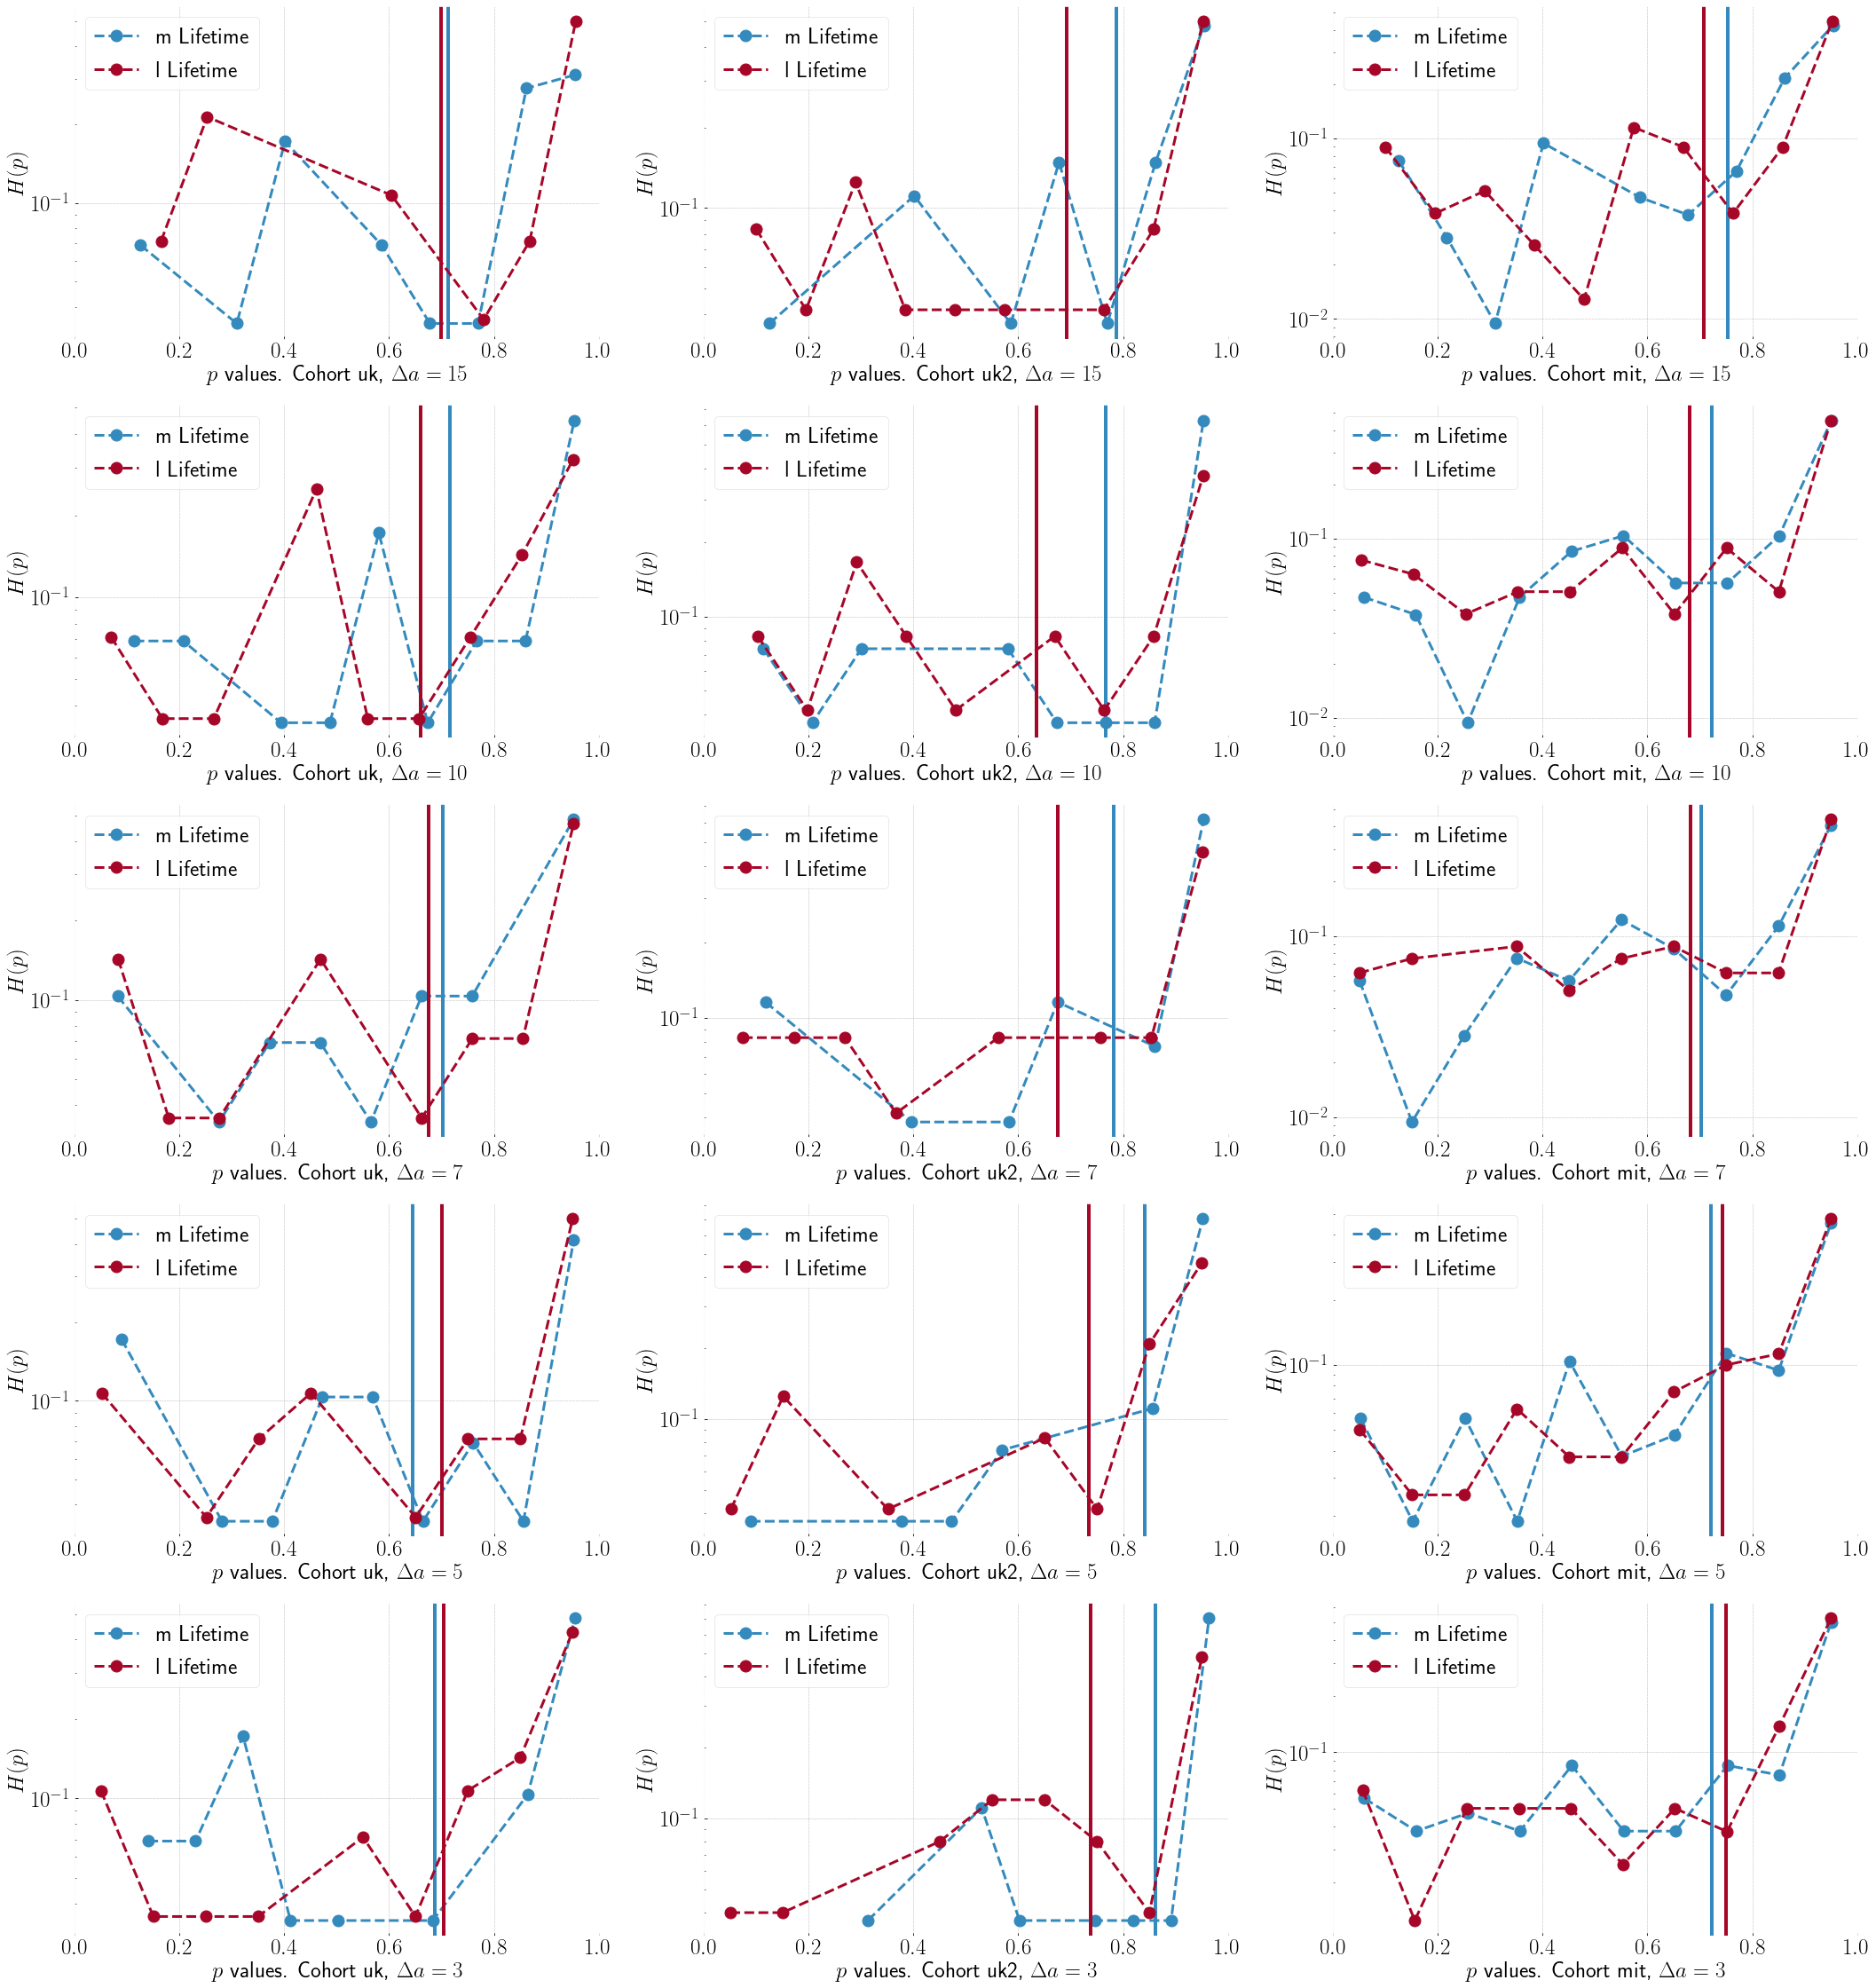

In [10]:
plt.figure(figsize=(12*3, 8*5))
p = 1
for Da in a.keys():
    for c in ksp.keys():
        plt.subplot(5, 3, p)
        plt.semilogy()
        plt.xlim(0, 1)
        plt.xlabel(fr"$p$ values. Cohort {c}, $\Delta a = {Da}$")
        plt.ylabel(r'$H(p)$')
        m = 0
        for s in ['m', 'l']:
            H = pc.histogram(ksp[c][Da][s], 10, log=False)
            H['tmp'] = H['label'] * H['h']
            avg = sum(H['tmp']) / sum(H['h'])
            plt.plot(H['label'], H['pmf'], marker=markers[0], markersize=13, ls="dashed", lw=3, c=colors[m], label=f"{s} Lifetime")
            plt.axvline(avg, ls="solid", lw=4, c=colors[m])
            m += 1
        plt.legend()
        p += 1
plt.savefig("/home/vsvh/Desktop/A.png", dpi=150, pad_inches=2)

## Using all cohorts and $\Delta a = 15$

In [36]:
ksp = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        left = df.loc[(df.index >= a[15][1][0]) & (df.index <= a[15][1][1])]
        right = df.loc[(df.index >= a[15][1][1]) & (df.index <= a[15][1][2])]
        if (len(left) >= 1) and (len(right) >= 1):
            ksp[c]['m'] = ksp[c].get('m', [])
            ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        left = df.loc[(df.index >= a[15][2][0]) & (df.index <= a[15][2][1])]
        right = df.loc[(df.index >= a[15][2][1]) & (df.index <= a[15][2][2])]
        if (len(left) >= 1) and (len(right) >= 1):
            ksp[c]['l'] = ksp[c].get('l', [])
            ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

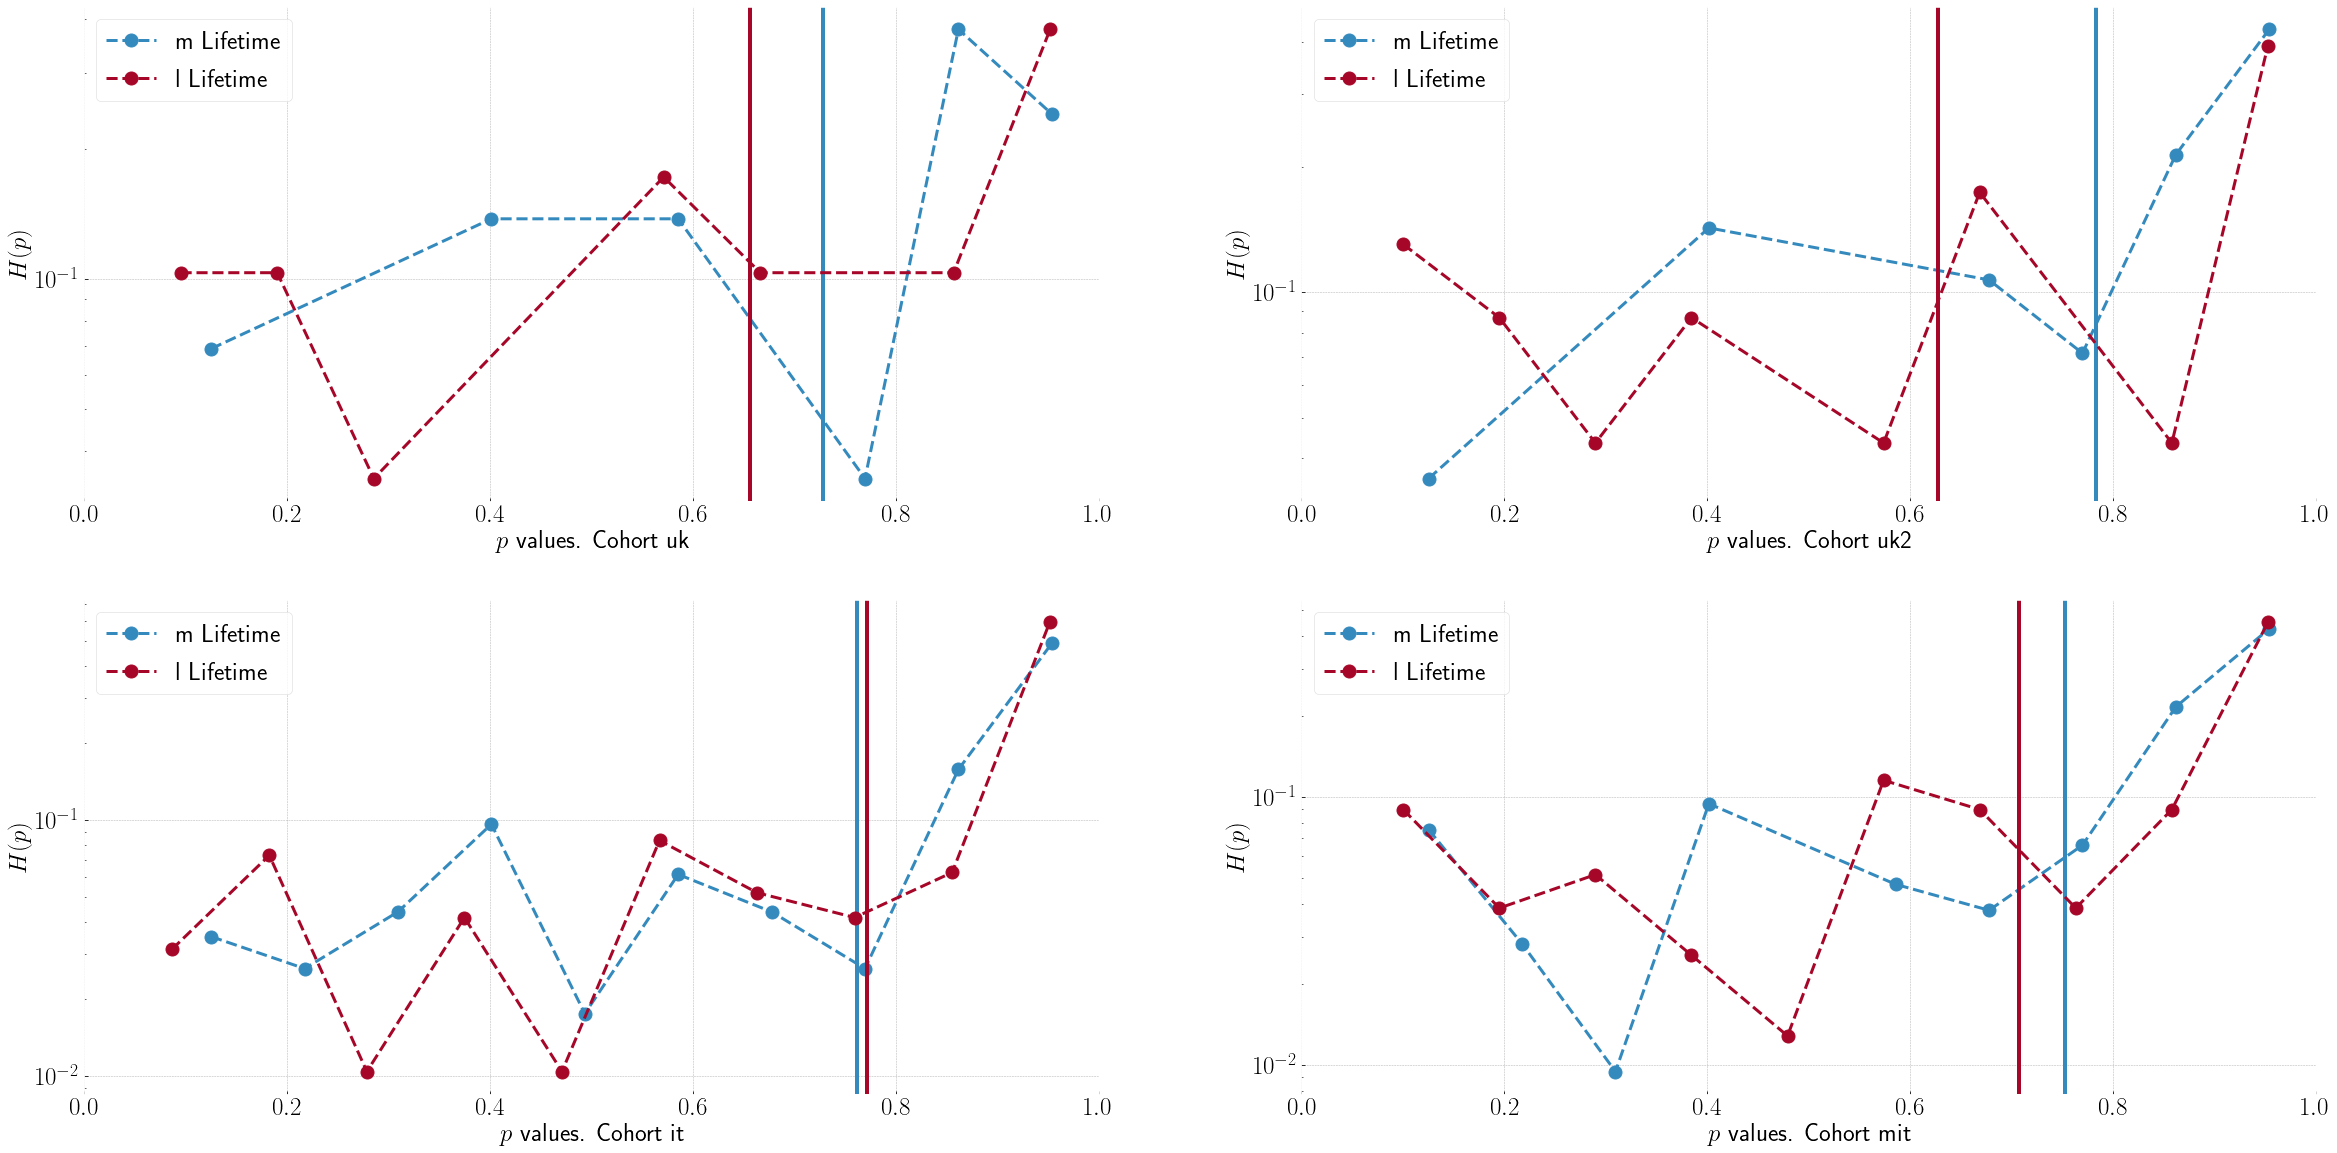

In [37]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ksp.keys():
    plt.subplot(2, 2, p)
    plt.semilogy()
    plt.xlim(0, 1)
    plt.xlabel(fr"$p$ values. Cohort {c}")
    plt.ylabel(r'$H(p)$')
    m = 0
    for s in ['m', 'l']:
        H = pc.histogram(ksp[c][s], 10, log=False)
        H['tmp'] = H['label'] * H['h']
        avg = sum(H['tmp']) / sum(H['h'])
        plt.plot(H['label'], H['pmf'], marker=markers[0], markersize=13, ls="dashed", lw=3, c=colors[m], label=f"{s} Lifetime")
        plt.axvline(avg, ls="solid", lw=4, c=colors[m])
        m += 1
    plt.legend()
    p += 1

# Explore relationship between $\ell$ and $b$

In [11]:
test = pc.get_fal(unfiltered['uk'], 200, 300, 15)

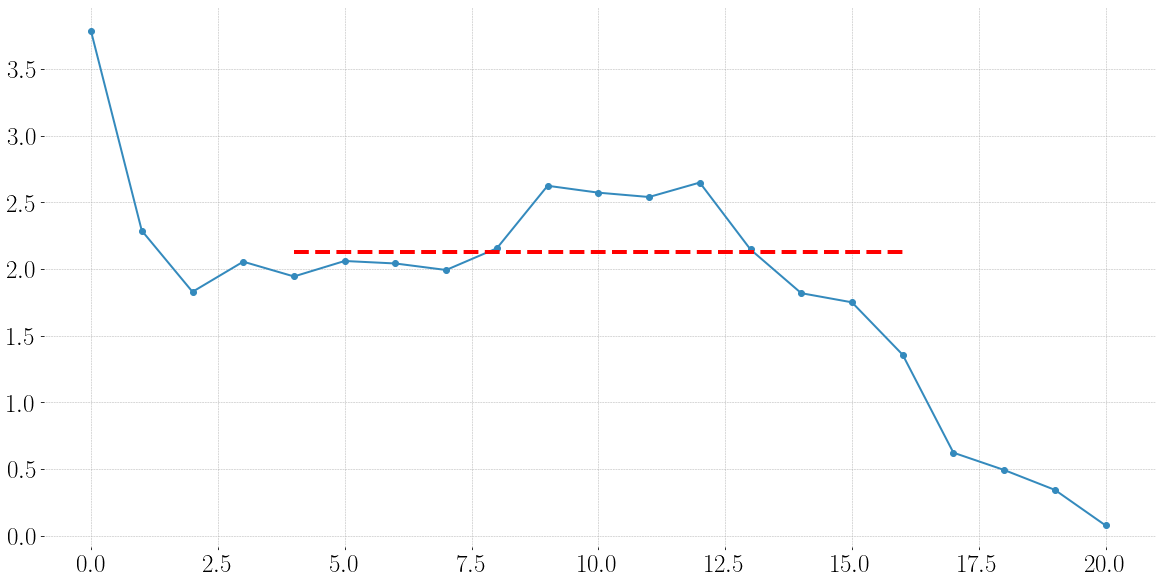

In [12]:
plt.plot(test['f'].index, test['f']['f'], "o-")
points = pc.get_plateau(test['f'])
plt.plot([x[0] for x in points], [y[1] for y in points], marker="", ls="dashed", lw=4, c="red")

In [13]:
fa = {}
for c in calls.keys():
    fa[c] = {}
    for ell in range(max(calls[c]['aclock'])):
        curve = pc.get_fal(calls[c], ell, ell + 30, 15)
        if (type(curve) == dict) and (len(curve['f']) > 5):
            points = pc.get_plateau(curve['f'], arbxo=1, arbxf=1)
            fa[c][ell] = points[0][1]
    fa[c] = pd.DataFrame.from_dict(fa[c], orient='index').sort_index()

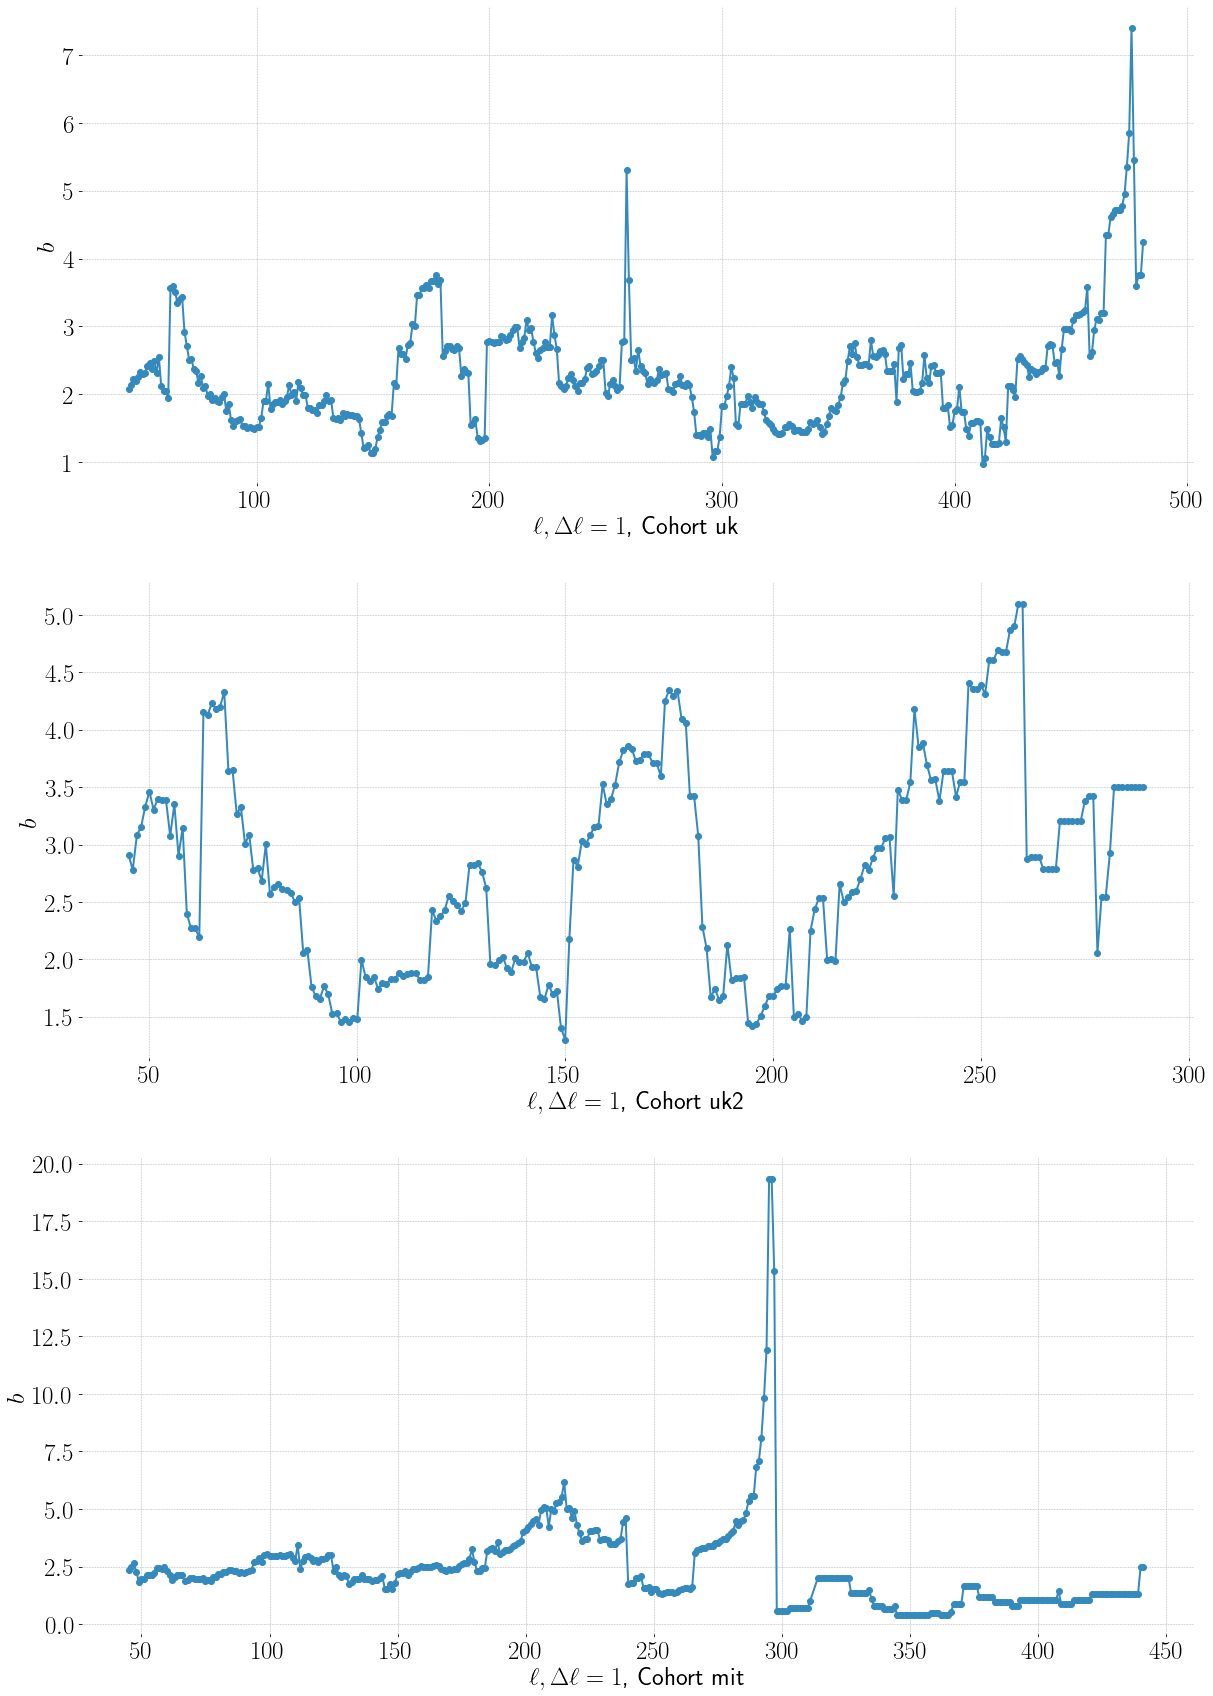

In [14]:
plt.figure(figsize=(20, 10*3))
p = 1
for c in fa.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(fr'$\ell, \Delta \ell = 1$, Cohort {c}')
    plt.ylabel(r'$b$')
    plt.plot(fa[c].index, fa[c][0], "o-")
    p += 1

# Global Time

In [15]:
globaltf = dt.datetime.now() - globalt0
print(f'This notebook took {globaltf}')
os.system(f"notify-send 'Notebook done' 'it took {globaltf}'")

This notebook took 0:02:27.704149


0